# De-projecting galaxy models into the original frame WCS

When originally creating subjects for galaxy builder, we used `Montage` to combine together multiple r-band images. However, the resulting image was reprojected to a different coordinate space. This reprojection makes it very difficult (read: impossible) to recover accurate statistics on the pixel error (due to the interpolation involved in resampling).

We wish to move galaxy builder models back into the WCS of the original frames, so that we can properly caluclate sigma images.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from descartes import PolygonPatch
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
import gzbuilder_analysis.parsing as pa
import lib.galaxy_utilities as gu
import lib.make_cutouts as mkct
from asinh_cmap import asinh_colormap
import gzbuilder_analysis.aggregation.average_shape_helpers as ash

Ignore a fits warning to make things prettier:

In [3]:
from astropy.wcs import WCS, FITSFixedWarning
import warnings

warnings.simplefilter('ignore', FITSFixedWarning)
# we'll be dividing by NaN a lot (regions of zero pixel coverage)
warnings.simplefilter('ignore', RuntimeWarning)

In [4]:
best_models = pd.read_pickle('lib/best_individual.pickle')

In [5]:
subject_id = np.random.choice(best_models.index)

Get the galaxy metadata, and information on the cutout to use:

In [6]:
gal, _ = gu.get_galaxy_and_angle(subject_id)
ra, dec = gu.metadata.loc[subject_id][['ra', 'dec']]
centre_pos, dx, dy = mkct.get_cutout_params(gal, ra, dec)

Extract data from the original frames, and create the new (not reprojected) cutout

In [7]:
frame_info = mkct.get_frame_data(subject_id)
stacked_image, sigma_image = mkct.generate_new_cutout(subject_id)
multiplier = gu.get_diff_data(subject_id)['multiplier']
original_data = gu.get_diff_data(subject_id)['imageData'] * multiplier

Open the montage-d frame, and plot it as an overlay on the frame:

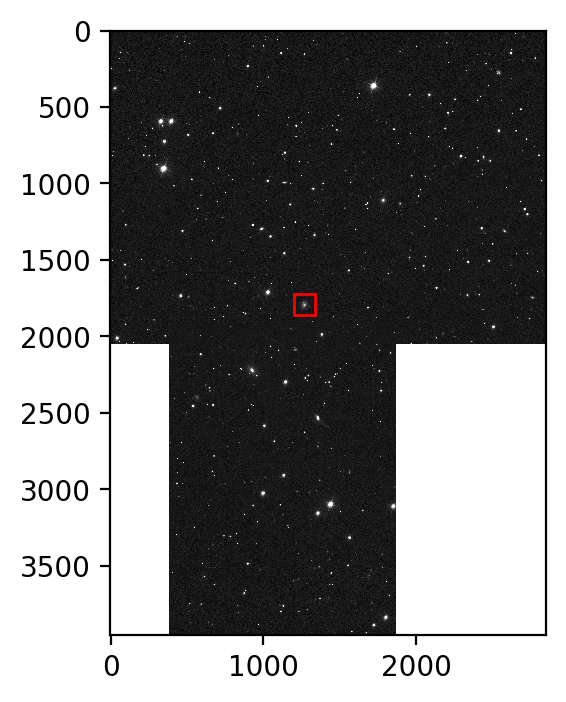

In [32]:
montage_fits = fits.open(mkct.get_frames(subject_id=subject_id)[1])
montage_cutout = Cutout2D(
    montage_fits[0].data,
    centre_pos,
    (dx, dy),
    wcs=WCS(montage_fits[0]),
    mode='partial',
    copy=True,
)
montage_wcs = montage_cutout.wcs
original_wcs = frame_info.wcs.iloc[0]
plt.figure(dpi=200)
plt.imshow(montage_fits[0].data, cmap=asinh_colormap,
           vmax=original_data.max(), vmin=original_data.min())
montage_cutout.plot_on_original(color='red')

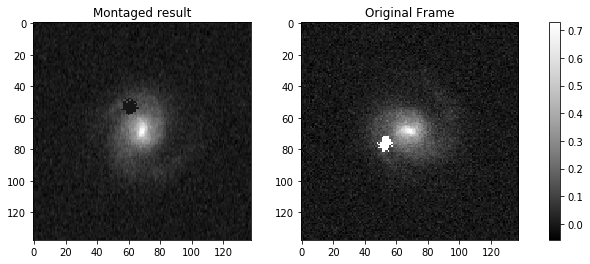

In [9]:
_, ax = plt.subplots(ncols=2, figsize=(11, 4))
ax[0].imshow(
    original_data, cmap=asinh_colormap,
    vmax=original_data.max(), vmin=original_data.min()
)
ax[0].set_title('Montaged result')
foo = ax[1].imshow(
    stacked_image, cmap=asinh_colormap,
    vmax=original_data.max(), vmin=original_data.min()
)
ax[1].set_title('Original Frame')
plt.colorbar(foo, ax=ax)

In [10]:
display('We want to go from:')
display(montage_wcs)
display('to')
display(original_wcs)

'We want to go from:'

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 243.843400024  30.803107233  
CRPIX : 223.0  252.5  
NAXIS : 138  138

'to'

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 243.834289944  30.6747727277  
CRPIX : -698.0  597.0  
CD1_1 CD1_2  : 6.9397075619e-05  8.53147114462e-05  
CD2_1 CD2_2  : 8.5345451268e-05  -6.9393814831e-05  
NAXIS : 138  138

The disk can be broken down into a centre point and two vectors representing the major and minor axis, which we can transform and plot:

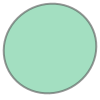

In [11]:
disk = best_models.loc[subject_id].Model['disk']
# correct for upside-down image
disk['roll'] = -disk['roll']
ash.make_ellipse(disk)

In [12]:
def rotation_matrix(r):
#     r = np.deg2rad(d)
    return np.array((
        (np.cos(r), np.sin(r)),
        (-np.sin(r), np.cos(r))
    ))

Extract the points for the disk centre, major and minor axis:

In [13]:
montage_centre = np.array((disk['mux'], disk['muy']))
montage_major_axis = (
    montage_centre
    + np.dot(rotation_matrix(disk['roll']), (disk['rEff'], 0))
)
montage_minor_axis = (
    montage_centre
    + np.dot(rotation_matrix(disk['roll'] + np.pi / 2), (disk['rEff'] * disk['axRatio'], 0))
)

array([107.43721985,  91.14256073])

Convert these points to world coordinates, then back to pixel coordinates in the original WCS

In [14]:
world_points = montage_wcs.all_pix2world([
    montage_centre, montage_major_axis, montage_minor_axis
], 0)
(
    original_centre, original_major_axis, original_minor_axis
) = original_wcs.all_world2pix(world_points, 0)

And reconstruct the Disk!

In [15]:
original_disk = {
    **disk,
    'mux': original_centre[0], 'muy': original_centre[1],
    'roll': -np.arctan2(*(original_major_axis - original_centre)[::-1]),
    'rEff': np.sqrt(np.add.reduce((original_major_axis - original_centre)**2)),
}
original_disk['axRatio'] = np.sqrt(np.add.reduce((original_minor_axis - original_centre)**2)) / original_disk['rEff']

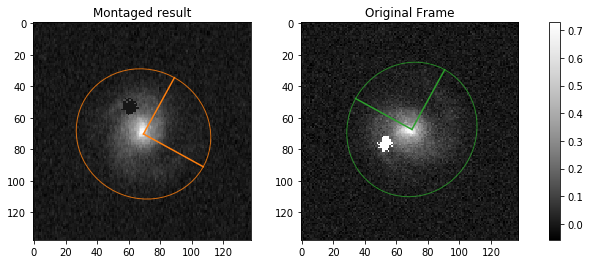

In [16]:
_, ax = plt.subplots(ncols=2, figsize=(11, 4))
ax[0].imshow(
    original_data, cmap=asinh_colormap,
    vmax=original_data.max(), vmin=original_data.min()
)
ax[0].plot(
    *np.stack((montage_centre, montage_major_axis), axis=1), c='C1'
)
ax[0].plot(
    *np.stack((montage_centre, montage_minor_axis), axis=1), c='C1'
)
ax[0].add_patch(PolygonPatch(ash.make_ellipse(disk), alpha=0.8, fc='none', ec='C1'))
ax[0].set_title('Montaged result')
foo = ax[1].imshow(
    stacked_image, cmap=asinh_colormap,
    vmax=original_data.max(), vmin=original_data.min()
)
ax[1].plot(
    *np.stack((original_centre, original_major_axis), axis=1), c='C2'
)
ax[1].plot(
    *np.stack((original_centre, original_minor_axis), axis=1), c='C2'
)
ax[1].add_patch(PolygonPatch(
    ash.make_ellipse(original_disk), alpha=0.8, fc='none', ec='C2'))
ax[1].set_title('Original Frame')
plt.colorbar(foo, ax=ax)

## Worked example of a classification

We'll grab a random classification made by me, and work through the parsing of the annotation (with and without WCS corrections) and rendering of the result:

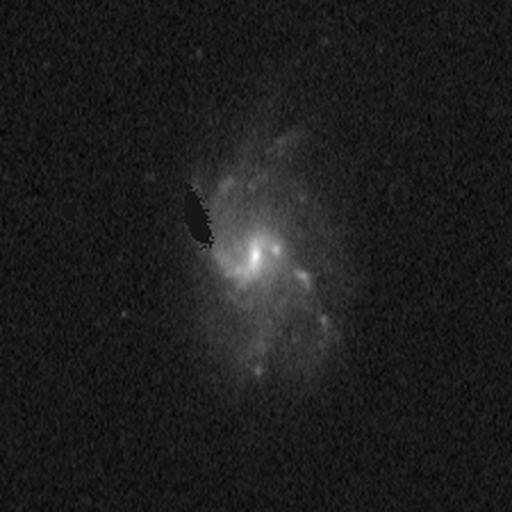

In [17]:
c = gu.classifications.query('user_name == "tingard" and 20000000 < subject_ids < 20905000').sample(1).iloc[0]
gu.get_image(c.subject_ids)

In [18]:
import json
import gzbuilder_analysis.parsing as pa

In [19]:
diff_data = gu.get_diff_data(c.subject_ids)
size_diff = diff_data['width'] / diff_data['imageWidth']

In [20]:
frame_info = mkct.get_frame_data(c.subject_ids)
stacked_image, sigma_image = mkct.generate_new_cutout(c.subject_ids)
multiplier = gu.get_diff_data(c.subject_ids)['multiplier']
montage_wcs = mkct.get_montaged_cutout(c.subject_ids).wcs
original_wcs = frame_info.iloc[0].wcs

In [21]:
ann = pa.parse_annotation(
    json.loads(c['annotations']),
    diff_data['imageData'].shape,
    size_diff=size_diff
)

ann2 = pa.parse_annotation(
    json.loads(c['annotations']),
    stacked_image.shape,
    size_diff=size_diff,
    wcs_in=montage_wcs,
    wcs_out=original_wcs
)

(0, 225)

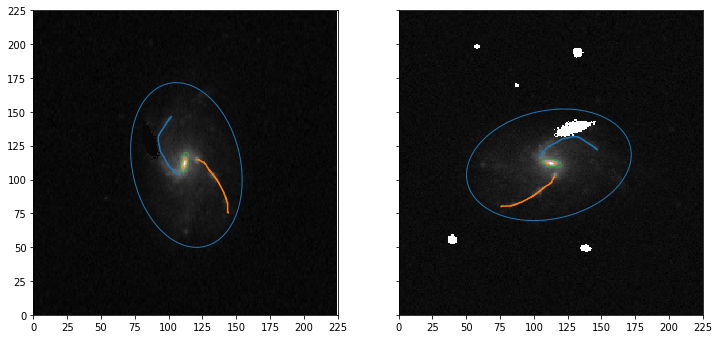

In [22]:
crop = 0
_, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 7))
plt.sca(ax[0])
plt.imshow(gu.get_diff_data(c.subject_ids)['imageData'], cmap=asinh_colormap)
if ann['disk']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann['disk']), alpha=1, fc='none', ec='C0'))
if ann['bulge']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann['bulge']), alpha=1, fc='none', ec='C1'))
if ann['bar']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann['bar']), alpha=1, fc='none', ec='C2'))
for s in ann['spiral']:
    plt.plot(*s[0].T)
plt.xlim(crop, stacked_image.shape[1]-crop)
plt.ylim(crop, stacked_image.shape[0]-crop)
plt.sca(ax[1])
plt.imshow(stacked_image, cmap=asinh_colormap)
if ann['disk']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann2['disk']), alpha=1, fc='none', ec='C0'))
if ann['bulge']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann2['bulge']), alpha=1, fc='none', ec='C1'))
if ann['bar']:
    plt.gca().add_patch(PolygonPatch(ash.make_ellipse(ann2['bar']), alpha=1, fc='none', ec='C2'))
for s in ann2['spiral']:
    plt.plot(*s[0].T)

plt.xlim(crop, stacked_image.shape[1]-crop)
plt.ylim(crop, stacked_image.shape[0]-crop)

In [23]:
psf = gu.get_psf(c.subject_ids)

(0, 225)

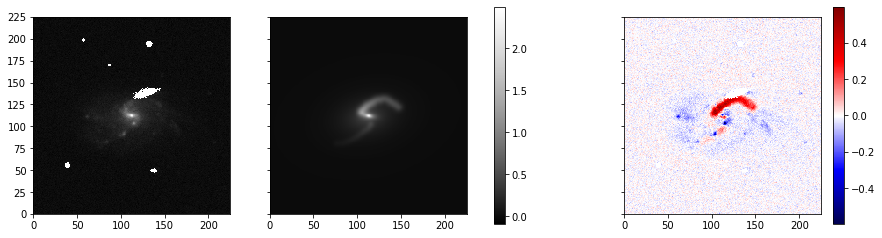

In [24]:
import gzbuilder_analysis.rendering as rg
_, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))
rendered_model = rg.calculate_model(
    ann2, image_size=stacked_image.shape[0],
    oversample_n=1,
    psf=psf,
) / 0.8 * multiplier
diff = rendered_model - stacked_image
# chisq = (diff**2 / sigma_image**2)[sigma_image.mask]
kw = dict(cmap=asinh_colormap, vmin=stacked_image.min(), vmax=stacked_image.max())
ax[0].imshow(stacked_image, **kw)
c_gal = ax[1].imshow(rendered_model, **kw)
plt.colorbar(c_gal, ax=ax[:2], shrink=.8)
c_diff = ax[2].imshow(diff , vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), cmap='seismic')
plt.colorbar(c_diff, ax=ax[2], shrink=.8)
plt.xlim(crop, stacked_image.shape[1]-crop)
plt.ylim(crop, stacked_image.shape[0]-crop)

In [25]:
np.multiply.reduce(sigma_image.shape), sigma_image.compressed().size

(50625, 50288)

In [30]:
print('Reduced chi-squared (empty model): {:.3f}'.format(
    np.sum((stacked_image.data / sigma_image).compressed()**2) / sigma_image.compressed().size
))
print('Reduced chi-squared (with model):  {:.3f}'.format(
    np.sum((diff / sigma_image).compressed()**2) / sigma_image.compressed().size
))

Reduced chi-squared (empty model): 7.223
Reduced chi-squared (with model):  2.456
